### Imports

In [1]:
from os.path import abspath, join
import pandas as pd
import numpy as np
from mizani.formatters import percent_format
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, geom_line,\
    scale_x_continuous, scale_y_continuous, scale_fill_manual

### Global constants
Files and paths

In [2]:
base_dir = "C:/Nitsan/third/JavaAnalyzer"
german_words_file = "german.csv"
german_compound_words_list = "german_compound.csv"

Graphs parameters

In [3]:
fill='#5a9cd9'
log_x_scale_labels = ["1", "2-10", "11-100", "101-1000", "1001-10000", "10001-100000"]

Column headers

In [4]:
name_col = "name"
length_col = "length"
word_count_col = "wordCount"
count_col = "count"
freq_col = "frequency"
rank_col = "rank"


# Comparison to English / German corpora
## Setup Coca corpus data:

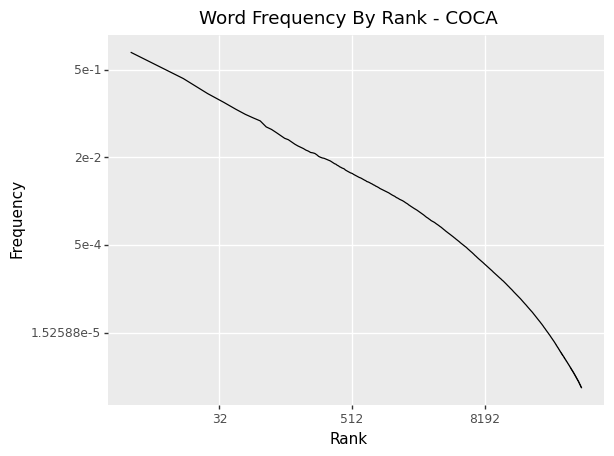

<ggplot: (138622253460)>
<ggplot: (138622285207)>


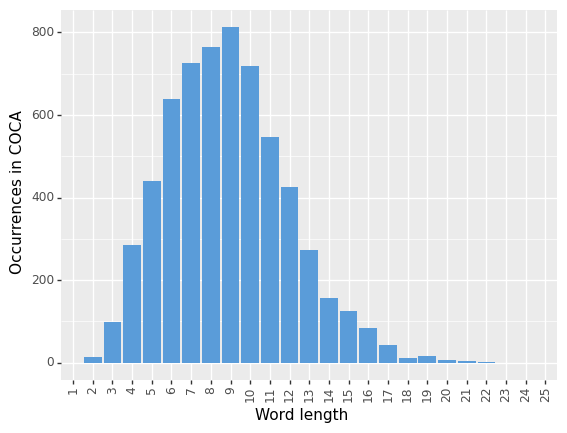

In [5]:
coca_data_file = "coca_sample.csv"
coca_df = pd.read_csv(abspath(join(base_dir, coca_data_file)))
coca_df[length_col] = coca_df['word'].str.len()

coca_word_freq = coca_df.groupby(["word", "rank"])[count_col].sum()\
	.reset_index()\
	.sort_values(count_col, ascending=False)
coca_most_freq_word_occurrences = int(coca_word_freq[:1][count_col])

coca_word_freq[count_col] = coca_word_freq[count_col] / coca_most_freq_word_occurrences

print(ggplot(coca_word_freq)
      + labs(x="Rank",
             y="Frequency",
             title="Word Frequency By Rank - COCA")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x=rank_col, y=count_col), stat='identity')
	  )

n = 25
coca_length_occurrences_df = coca_df.groupby([length_col]).size().reset_index(name=count_col)
coca_length_occurrences_df = coca_length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(coca_length_occurrences_df)
	+ labs(x="Word length",
		   y="Occurrences in COCA")
	+ scale_x_discrete(limits=range(1, 26))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)


## Load German corpus data

In [6]:
german_df = pd.read_csv(abspath(join(base_dir, german_words_file)))
german_df = german_df.groupby([name_col]).frequency.sum().reset_index().sort_values(freq_col, ascending=False)
compound_words_df = pd.read_csv(abspath(join(base_dir, german_compound_words_list)))
compound_words_df["compound_word"] = compound_words_df["compound_word"].str.lower()
compound_words_set = set(compound_words_df["compound_word"])

### Define splitting function - recursively remove word head and apply function on tail:

In [7]:
def count_compound_word_parts(compound_word, count=0):
    word = str(compound_word).lower()
    if word is not None and word in compound_words_set:
        return count_compound_word_parts(
            compound_words_df[compound_words_df["compound_word"] == word].remainder.array[0],
            count + 1
        )
    else:
        return count + 1


german_df[word_count_col] = german_df[name_col].apply(count_compound_word_parts).astype('category')

### German data sample:

In [8]:
print(german_df.sample(frac=1))

                 name     frequency wordCount
23477  Gegebenenfalls   4897.267794         1
77350          glänzt  32785.227230         1
36955          Ligeti   6141.648202         1
69575          befuhr  14057.000000         1
5529         Aegerter   4262.379172         1
...               ...           ...       ...
93207      übernahmen  66456.000000         1
27441    Hechtsheimer  10198.000000         1
12393         Briefes  12925.000000         1
51400   Schneetreiben   7273.000000         2
52517    Seitensprung   7686.000000         2

[93406 rows x 3 columns]


c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


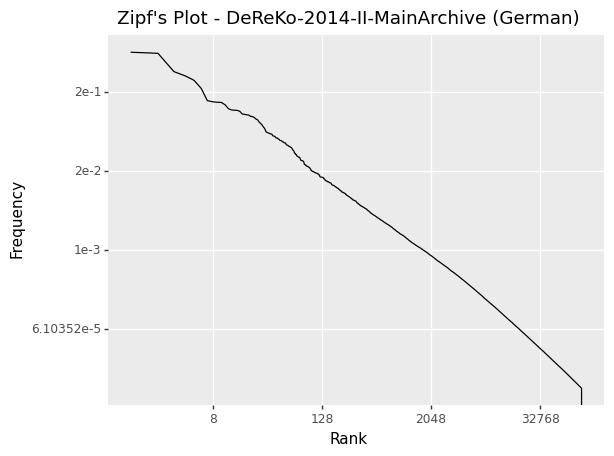

<ggplot: (138569930493)>
<ggplot: (138622425604)>
<ggplot: (138624821788)>


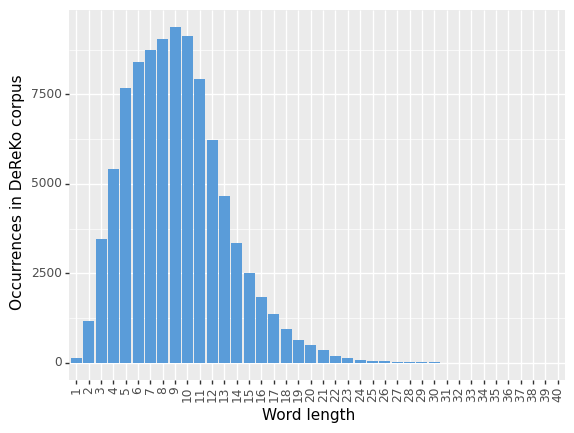

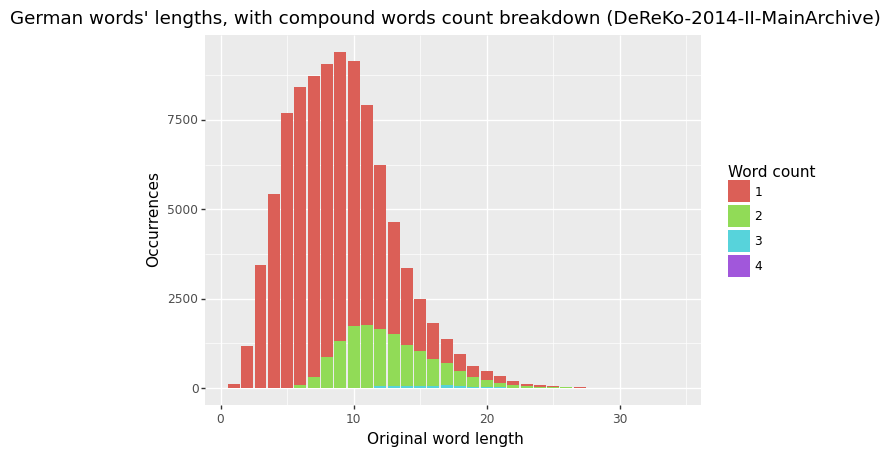

In [9]:
german_most_freq_word_occurrences = int(german_df[:1][freq_col])
german_df[freq_col] = german_df[freq_col] / german_most_freq_word_occurrences
german_df_length = german_df.shape[0]
german_df[rank_col] = np.linspace(1, german_df_length, german_df_length)

print(
    ggplot(german_df)
    + labs(x="Rank",
         y="Frequency",
         title="Zipf's Plot - DeReKo-2014-II-MainArchive (German)")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)

german_df[length_col] = german_df[name_col].str.len()
n = 40
german_length_occurrences_df = german_df.groupby([length_col]).size().reset_index(name=count_col)
german_length_occurrences_df = german_length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(german_length_occurrences_df)
	+ labs(x="Word length",
		   y="Occurrences in DeReKo corpus")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

print(
	ggplot(german_df)
	+ labs(x="Original word length",
		   y="Occurrences",
		   title="German words' lengths, with compound words count breakdown (DeReKo-2014-II-MainArchive)",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
)

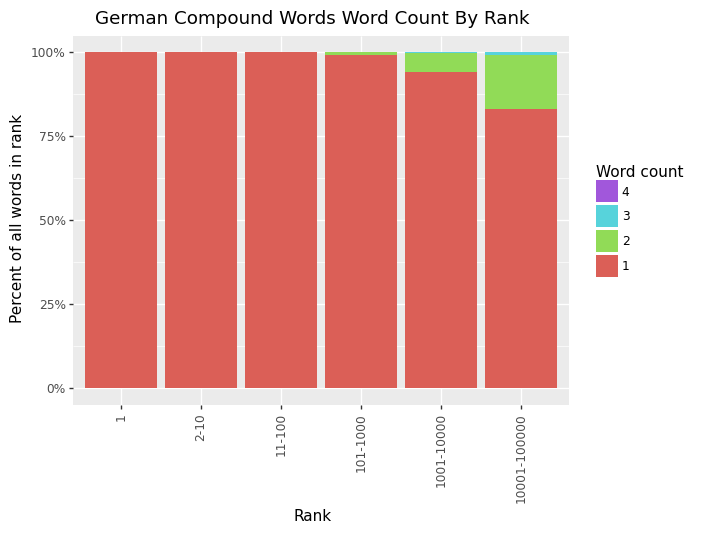

<ggplot: (138625121485)>


In [10]:
bin_count = int(np.ceil(np.math.log(german_df.shape[0])))
german_df["rank_bin"] = pd.cut(german_df[rank_col], bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))
german_df[word_count_col] = pd.Categorical(german_df[word_count_col],
                                             categories=list(range(4, 0, -1)),
                                             ordered=True)
print(
    ggplot(german_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="German Compound Words Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', fill=word_count_col), position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + scale_fill_manual(["#a157db", "#57d3db","#91db57", "#db5f57"]) # unfortunate hack
    + theme(axis_text_x=element_text(rotation=90))
)